In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
import copy
from matplotlib.patches import Ellipse

In [2]:
dataset = np.load('dataset.npz')

In [19]:
dt = 0.1
N = 12609
dt = 0.1
num_landmarks = 17
landmark = dataset['l']
x_landmark = landmark[:, 0]
y_landmark = landmark[:, 1]
velocity = dataset['v']
angular_velocity = dataset['om']
distance_measured = dataset['r']
bearing_measured = dataset['b']
dist_btw_robot_and_laser = dataset['d'][0][0]
var_velocity = dataset['v_var'][0][0]
var_ang_velocity = dataset['om_var'][0][0] 
var_distance_control = dataset['r_var'][0][0]
var_angular_control = dataset['b_var'][0][0]

In [17]:
x_motion = []
y_motion = []
th_motion = []

x_motion.append(dataset['x_true'][0][0]) 
y_motion.append(dataset['y_true'][0][0])
th_motion.append(dataset['th_true'][0][0])

for i in range(1, len(dataset['v'])):
    x_motion.append(x_motion[i-1] + dt * np.cos(th_motion[i-1]) * velocity[i])
    y_motion.append(y_motion[i-1] + dt * np.sin(th_motion[i-1]) * velocity[i])
    th_motion.append(th_motion[i-1] + dt * angular_velocity[i])

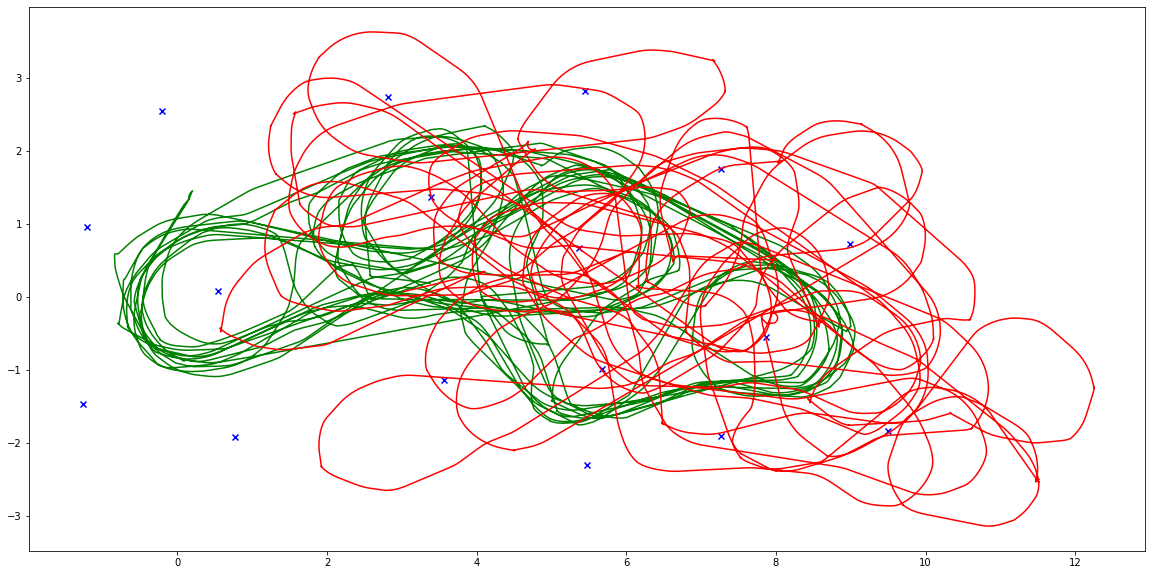

In [18]:
plt.figure(figsize=(20,10))
plt.plot(dataset['x_true'], dataset['y_true'], c='g')
plt.plot(x_motion, y_motion, c='r')
plt.scatter(x_landmark, y_landmark, c='b', marker = 'x')

In [7]:
print(dataset['om_var'])
print(dataset['r_var'])

[[0.00818609]]
[[0.00090036]]


In [8]:
def range_to_pi(x):
    return (x + np.pi) % (2 * np.pi ) - np.pi

In [20]:
'''
    x = [x_coord, y_coord, angle_of_rotation]
'''

x = np.array([dataset['x_true'][0][0], dataset['y_true'][0][0], dataset['th_true'][0][0]])

# Initial Prediction/ Estimate
x_e = copy.deepcopy(x)

# Initial robot covariance belief 
P = np.diag([1, 1, 0.1])

# Measurement covariance belief 
Q = np.diag([var_velocity, var_ang_velocity])

x_e_t = np.zeros([N, 3])
P_mat = np.zeros([N,3,3])

In [21]:

for i in range(N):
    x_e_t[i] = x_e
    P_mat[i] = P
    
    v = velocity[i][0]
    v_ang = angular_velocity[i][0]
    
    # Update Position estimation
    x_coord = x_e[0]
    y_coord = x_e[1]
    theta = x_e[2]
    
    distance = v * dt
    rotation = v_ang * dt
    
    x_coord_new = x_coord + distance * np.cos(theta + rotation)
    y_coord_new = y_coord + distance * np.sin(theta + rotation)
    theta_new = range_to_pi(theta + rotation)
    
    # New Estimation
    x_e = np.array([x_coord_new, y_coord_new, theta_new])
    
    # Grad of f = F = df/dx
    F = np.array([[1, 0, -distance * np.sin(theta + rotation)],
                  [0, 1, distance * np.cos(theta + rotation)],
                  [0, 0, 1]])
    
    # Grad of g = G = dg/du
    G = np.array([[np.cos(theta + rotation), -distance * np.sin(theta + rotation)],
                  [np.sin(theta + rotation), distance * np.cos(theta + rotation)],
                  [0, 1]])
    
    P = F @ P @ F.T + G @ Q @ G.T
    
    for l in range(num_landmarks):
        dist_measured = distance_measured[i][l]
        angle_measured = bearing_measured[i][l]
        
        if dist_measured == 0:
            continue
        
        landmark_x = landmark[l][0]
        landmark_y = landmark[l][1]
        
        ''' 
            Distance Formula
            dist = sqrt((x_m - x_e)^2 + (y_m - y_e)^2)^(1/2)
            
            Angle Formula
            angle = atan((y_m - y_e)/(x_m - x_e)) - angle_e
        '''
    
        
        px = landmark_x - x_e[0] - dist_btw_robot_and_laser * np.cos(x_e[2])
        py = landmark_y - x_e[1] - dist_btw_robot_and_laser * np.sin(x_e[2])
        
        dist_estimate = (px**2 + py**2)**(0.5)
        
        th_y = landmark_y - x_e[1] - dist_btw_robot_and_laser * np.sin(x_e[2])
        th_x = landmark_x - x_e[0] - dist_btw_robot_and_laser * np.cos(x_e[2])
        angle_estimate = range_to_pi(np.arctan2(th_y, th_x) - x_e[2])
        
        
        # Grad of Z = H = dZ/dx     
        dist_1 = -(landmark_x - x_e[0])/dist_estimate
        dist_2 = -(landmark_y - x_e[1])/dist_estimate
        dist_3 = dist_btw_robot_and_laser/dist_estimate * (px * np.sin(x_e[2]) - py * np.cos(x_e[2]))

        dist_diff = np.array([dist_1, dist_2, dist_3])
        
        angle_1 = (landmark_y - x_e[1])/dist_estimate**2
        angle_2 = -(landmark_x - x_e[0])/dist_estimate**2
        angle_3 = -dist_btw_robot_and_laser/dist_estimate**2 * (th_x * np.cos(x_e[2]) + th_y * np.sin(x_e[2])) - 1
        angle_diff = np.array([angle_1, angle_2, angle_3])
        
        Z_measured = np.array([dist_measured, angle_measured])
        Z_estimated = np.array([dist_estimate, angle_estimate])
        H = np.vstack((dist_diff, angle_diff))
        R = np.diag([var_distance_control, var_angular_control])
        
        S = H @ P @ H.T + R
        S = np.array(S, dtype='float')
        K = P @ H.T @ np.linalg.inv(S)

        Z_diff = Z_measured - Z_estimated

       
        x_e = x_e + K @ Z_diff
        x_e[2] = range_to_pi(x_e[2])


        P = (np.eye(3) - K @ H) @ P
    

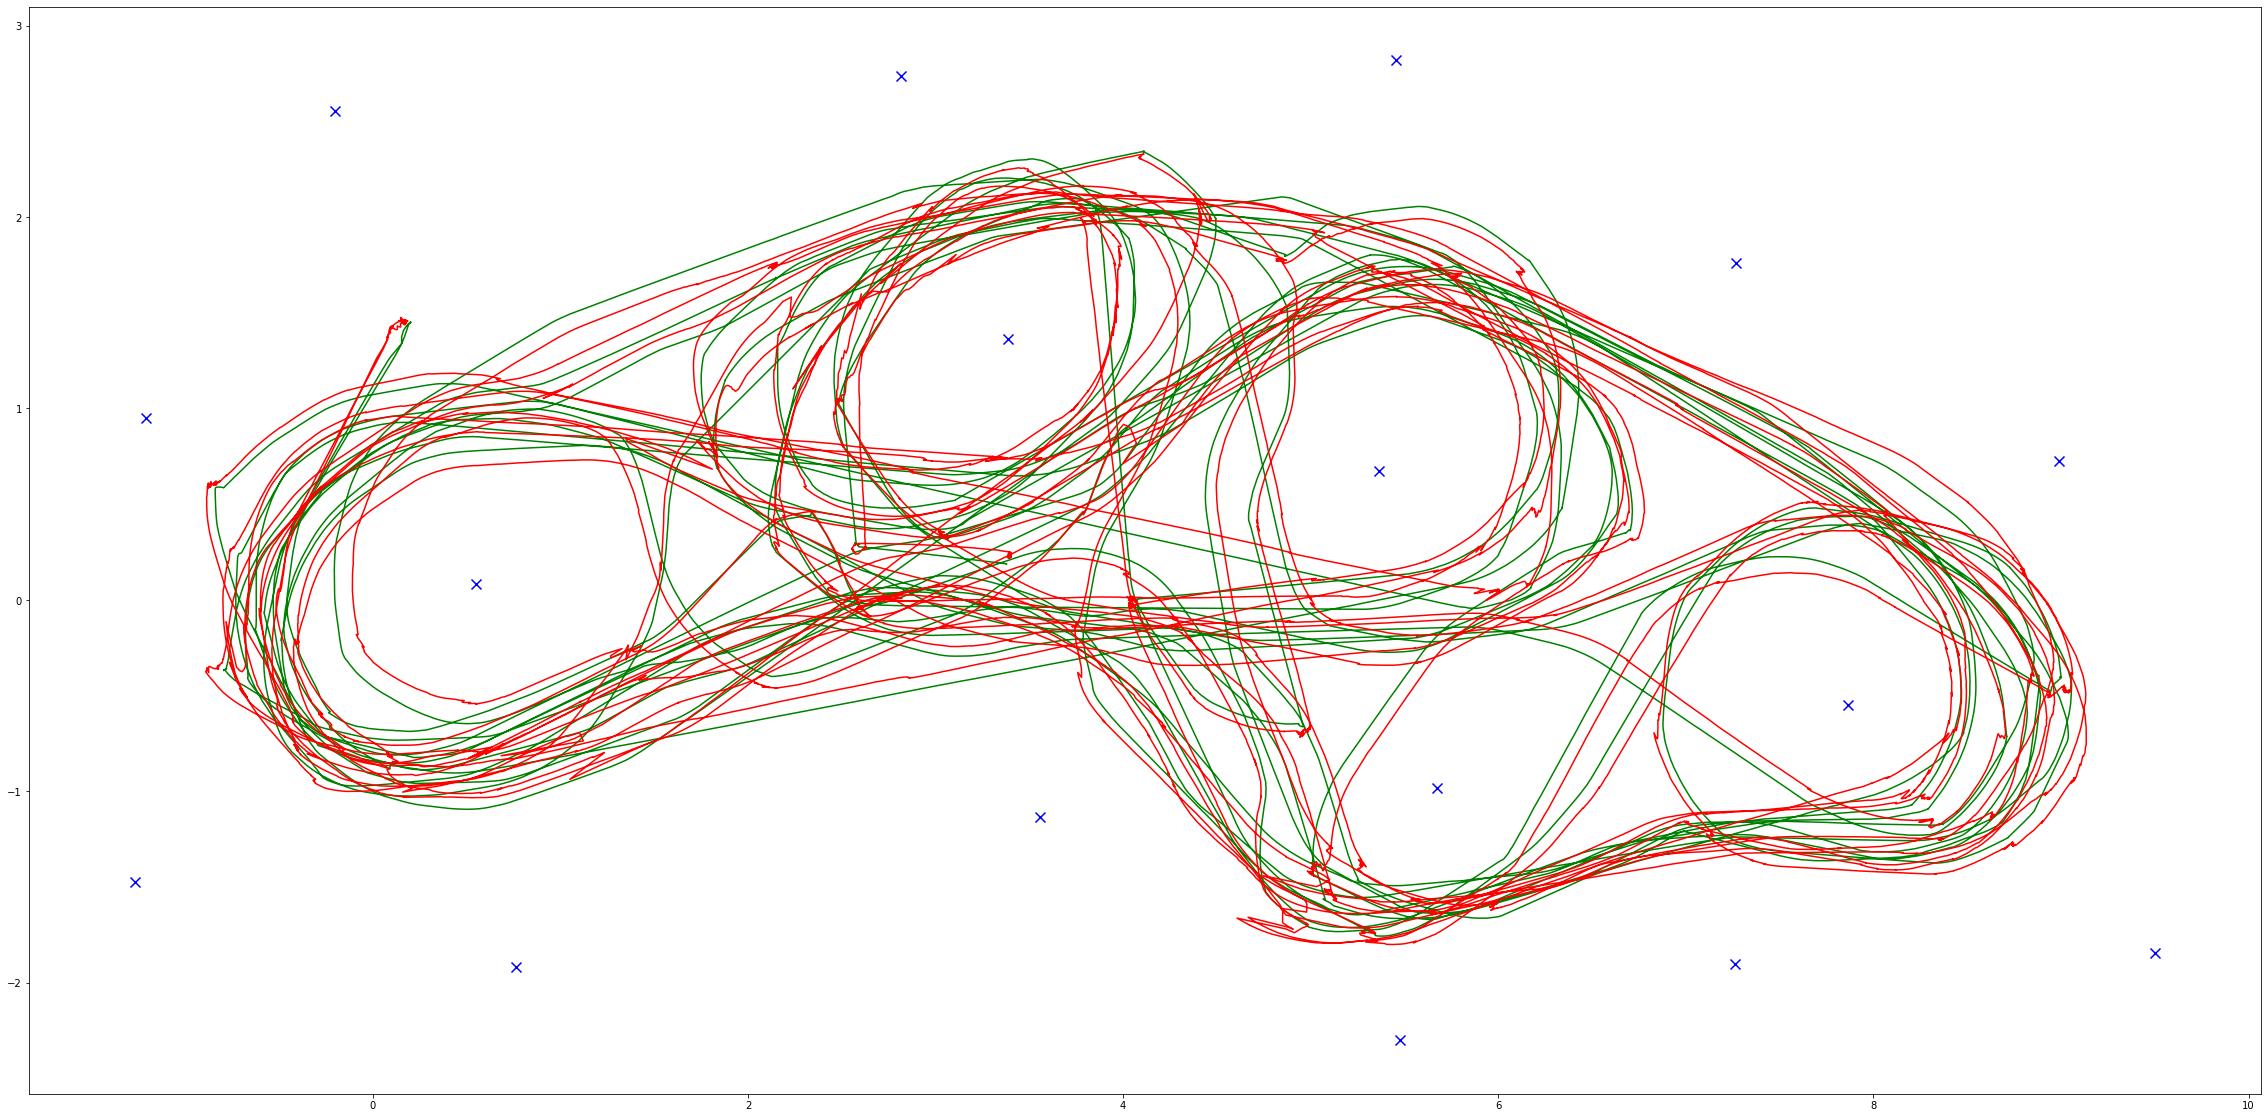

In [22]:
plt.figure(figsize=(40,20))
plt.plot(dataset['x_true'], dataset['y_true'], c='g')
plt.plot(x_e_t[:, 0], x_e_t[:, 1], c='r')
plt.scatter(x_landmark, y_landmark, s=100, c='b', marker = 'x')

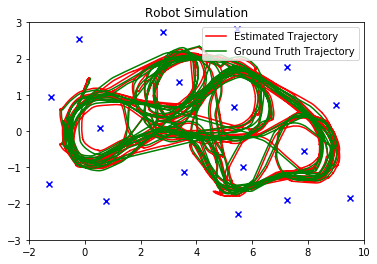

In [23]:
# Bonus Images
scale = 20
fig = plt.figure() 
ax = plt.axes(xlim=(-2, 10), ylim=(-3, 3)) 
ax.title.set_text('Robot Simulation')
line, = ax.plot([], [], c='r', label='Estimated Trajectory') 
line2, = ax.plot([], [], c='g', label='Ground Truth Trajectory') 
land_marks = ax.scatter(landmark[:, 0], landmark[:, 1], c='b', marker='x')
ax.legend(loc='upper right')

def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    line2.set_data([], [])
    
    return line, line2, 

xdata, ydata = [], [] 
xdata_ground, ydata_ground = [], [] 


def animate(i): 
      
    x = x_e_t[i, 0]
    y = x_e_t[i, 1]
    theta = x_e_t[i,2]
    
    x_ground = dataset['x_true'][i][0]
    y_ground = dataset['y_true'][i][0]
      
    # appending new points to x, y axes points list 
    xdata.append(x) 
    ydata.append(y) 
    
    xdata_ground.append(x_ground)
    ydata_ground.append(y_ground)
    
    # set/update the x and y axes data 
    line.set_data(xdata, ydata) 
    line2.set_data(xdata_ground, ydata_ground) 
    
#     ellipse = plot_ellipse(ax,np.array([x,y]),P_mat[i][:2,:2])
    vals, vecs = np.linalg.eigh(P_mat[i][:2,:2])
    xp, yp = vecs[:, 0]
    theta = np.degrees(np.arctan2(yp, xp))
    w, h = 2 * np.sqrt(vals) * scale
    ellipse = Ellipse(xy=np.array([x,y]), width=w, height=h, angle=theta)

    [p.remove() for p in reversed(ax.patches)]
    ax.add_patch(ellipse)
    
    return line, line2, land_marks, ellipse

anim = FuncAnimation(fig, animate, init_func=init,frames=N, interval=20, blit=True) 

anim.save('simulation.mp4', writer = 'ffmpeg', fps = 90) 
  
# show the plot 
plt.show() 

In [14]:
print(P_mat[4][:2,:2])

[[1.54334488e-04 2.38397404e-05]
 [2.38397404e-05 8.12775382e-05]]
